## Step 0: Install Required Packages (Run this first!)

If you get a "ModuleNotFoundError", run this cell to install the required packages.

In [ ]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scipy

## Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Define Parameters

In [ ]:
# Define genotypes and data directories
genotypes = {
    'WT': 'WT compiled_data',
    'dr170': 'dr170 compiled_data (1)',
    'dr180': 'dr180 compiled_data',
    'dr170 dr180': 'dr170 dr180 compiled_data (1)'
}

# Quality threshold for fit
FIT_THRESHOLD = 0.9

# Time window for V0 calculation (first 5 seconds)
V0_TIME_WINDOW = 5.0

# Smoothing window (seconds)
SMOOTHING_WINDOW = 5.0

# Colors for each genotype (line, SEM envelope)
colors = {
    'WT': {'line': 'black', 'fill': 'lightgrey'},
    'dr170': {'line': 'red', 'fill': 'pink'},
    'dr180': {'line': 'blue', 'fill': 'lightblue'},
    'dr170 dr180': {'line': 'orange', 'fill': 'moccasin'}
}

print(f"Parameters set:")
print(f"  Genotypes: {list(genotypes.keys())}")
print(f"  Fit threshold: {FIT_THRESHOLD}")
print(f"  V0 time window: {V0_TIME_WINDOW} seconds")
print(f"  Smoothing window: {SMOOTHING_WINDOW} seconds")

## Step 3: Load Data for WT

In [15]:
# Load WT data
genotype = 'WT'
data_dir = genotypes[genotype]
base_path = Path(data_dir)

wt_area = pd.read_csv(base_path / f'{genotype} compiled_area.csv')
wt_length = pd.read_csv(base_path / f'{genotype} compiled_length.csv')
wt_fit = pd.read_csv(base_path / f'{genotype} compiled_fit.csv')

print(f"WT data loaded:")
print(f"  Shape: {wt_area.shape}")
print(f"  Timepoints: {len(wt_area)}")
print(f"  Tracks: {len([c for c in wt_area.columns if c not in ['Frame', 'Time']])}")
print(f"\nFirst few rows:")
wt_area.head()

WT data loaded:
  Shape: (8541, 21)
  Timepoints: 8541
  Tracks: 19

First few rows:


,Frame,Time,WT_550_0003_1,WT_550_0003_2,WT_550_0003_3,WT_550_0003_4,WT_550_0003_6,WT2_5500001_1,WT2_5500001_2,WT2_5500001_3,...,WT2_5500001_5,WT2_5500001_6,WT2_5500001_7,WT2_5500001_8,WT2_5500001_9,WT2_5500001_10,WT3_5500001_2,WT3_5500001_5,WT3_5500001_8,WT3_5500001_9
0,1.0,0.000000,66863.519276,71853.867669,55001.028738,71706.763921,64983.801632,55497.392584,57385.174254,65093.300738,...,60053.190480,52034.630388,55954.238397,58906.872326,NaN,NaN,51941.159791,51049.984050,52115.040832,57101.109107
1,2.0,0.071429,68228.672217,71217.828618,60232.747111,70145.430663,67057.282967,54610.550485,57076.546696,64056.838888,...,61453.824563,52708.771366,56818.529173,60270.280776,52404.128717,NaN,54779.665973,53253.034524,54901.542413,57293.040260
2,3.0,0.142857,64874.222293,70227.633982,55850.553479,72642.332141,65424.296737,53850.116464,56326.220763,63440.795616,...,61006.520923,51707.691708,56125.110060,61860.621442,44840.543750,46990.467932,53169.051772,52089.840036,55601.353743,58207.544788
3,4.0,0.214286,65065.615530,72678.273383,59301.724061,72302.017955,65391.009344,56458.450490,55245.453772,62745.339970,...,60747.758018,51292.516536,56953.154766,61906.278502,55340.471053,57464.241911,53664.991158,54394.011310,53918.816410,57000.243110
4,5.0,0.285714,63763.673212,74861.644522,62747.312697,71661.381569,63368.574659,56896.922658,59077.218078,65136.054554,...,62975.584334,54283.995206,53886.303007,63537.090042,58385.577741,55231.164223,51829.414301,50152.919128,50259.727793,60363.287206


## Step 4: Calculate Volume for WT

In [16]:
# Calculate volume using V = π * Area² / (4 * Length)
wt_volume = wt_area.copy()
track_cols = [col for col in wt_area.columns if col not in ['Frame', 'Time']]

for col in track_cols:
    wt_volume[col] = (np.pi * wt_area[col]**2) / (4 * wt_length[col])

print(f"Volume calculated for {len(track_cols)} tracks")
print(f"\nSample volume values (first track, first 5 timepoints):")
print(wt_volume[[track_cols[0]]].head())

Volume calculated for 19 tracks

Sample volume values (first track, first 5 timepoints):
   WT_550_0003_1
0   3.587359e+06
1   3.524172e+06
2   3.338642e+06
3   3.317984e+06
4   3.281932e+06


## Step 5: Filter WT Data by Fit Quality

In [17]:
# Filter by fit quality
wt_volume_filtered = wt_volume.copy()

for col in track_cols:
    if col in wt_fit.columns:
        mask = wt_fit[col] < FIT_THRESHOLD
        wt_volume_filtered.loc[mask, col] = np.nan

# Count how many values were filtered out
original_count = wt_volume[track_cols].notna().sum().sum()
filtered_count = wt_volume_filtered[track_cols].notna().sum().sum()
removed = original_count - filtered_count

print(f"Fit filtering complete:")
print(f"  Original valid values: {original_count}")
print(f"  After filtering: {filtered_count}")
print(f"  Removed: {removed} ({100*removed/original_count:.1f}%)")

Fit filtering complete:
  Original valid values: 159139
  After filtering: 153169
  Removed: 5970 (3.8%)


## Step 6: Normalize WT to V0

In [18]:
# Normalize to V0 (average of first 5 seconds)
wt_normalized = wt_volume_filtered.copy()
v0_mask = wt_volume_filtered['Time'] <= V0_TIME_WINDOW

for col in track_cols:
    v0 = wt_volume_filtered.loc[v0_mask, col].mean()
    if not np.isnan(v0) and v0 > 0:
        wt_normalized[col] = (wt_volume_filtered[col] / v0) * 100
    else:
        wt_normalized[col] = np.nan

print(f"Normalization complete")
print(f"\nSample normalized values (should be ~100% at t=0):")
print(wt_normalized[[track_cols[0]]].head())

Normalization complete

Sample normalized values (should be ~100% at t=0):
   WT_550_0003_1
0            NaN
1     107.909884
2     102.228951
3     101.596421
4     100.492501


## Step 6.5: Define Smoothing Function

In [19]:
def smooth_data(summary_df, window_seconds=5.0):
    """
    Apply rolling average smoothing to the summary data.
    
    Parameters:
    -----------
    summary_df : DataFrame
        Summary data with Time, Mean, SEM columns
    window_seconds : float
        Time window for smoothing (in seconds)
    
    Returns:
    --------
    smoothed_df : DataFrame
        Smoothed summary data
    """
    # Calculate the time interval between measurements
    time_diff = summary_df['Time'].diff().median()
    
    # Calculate window size in number of points
    window_size = int(window_seconds / time_diff)
    window_size = max(1, window_size)  # Ensure at least 1
    
    # Apply rolling mean
    smoothed_df = summary_df.copy()
    smoothed_df['Mean'] = summary_df['Mean'].rolling(window=window_size, center=True, min_periods=1).mean()
    smoothed_df['SEM'] = summary_df['SEM'].rolling(window=window_size, center=True, min_periods=1).mean()
    
    return smoothed_df

print(f"Smoothing function defined (window: {SMOOTHING_WINDOW} seconds)")

NameError: name 'SMOOTHING_WINDOW' is not defined

## Step 7: Calculate Mean and SEM for WT

In [7]:
# Calculate mean and SEM across tracks
wt_mean = wt_normalized[track_cols].mean(axis=1, skipna=True)
wt_sem = wt_normalized[track_cols].sem(axis=1, skipna=True)
wt_n = wt_normalized[track_cols].count(axis=1)

wt_summary = pd.DataFrame({
    'Time': wt_normalized['Time'],
    'Mean': wt_mean,
    'SEM': wt_sem,
    'N': wt_n
})

print(f"Summary statistics calculated")
print(f"\nFirst 10 timepoints:")
wt_summary.head(10)

Summary statistics calculated

First 10 timepoints:


,Time,Mean,SEM,N
0,0.000000,98.668244,1.461314,16
1,0.071429,101.948289,1.831415,18
2,0.142857,97.788370,2.065833,18
3,0.214286,102.025407,1.284022,19
4,0.285714,103.067560,1.310370,19
5,0.357143,104.166672,0.868306,19
6,0.428571,101.336255,1.154397,19
7,0.500000,99.118026,1.741411,19
8,0.571429,101.990850,1.419044,17
9,0.642857,100.356661,1.308550,19


## Step 8: Plot WT Data

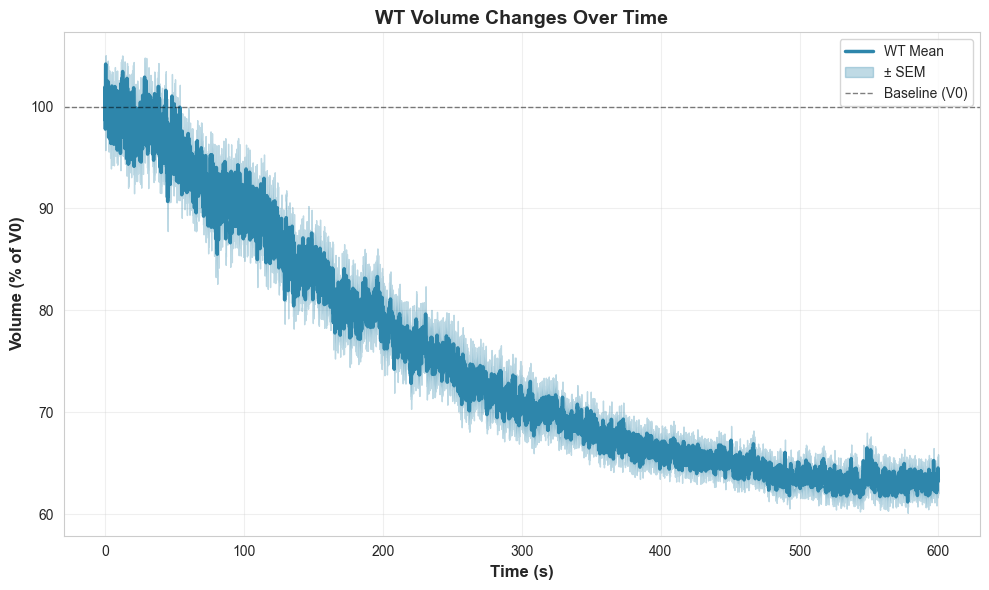

WT analysis complete!


In [ ]:
# Smooth the WT data
wt_summary_smoothed = smooth_data(wt_summary, SMOOTHING_WINDOW)

# Plot WT mean ± SEM
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wt_summary_smoothed['Time'], wt_summary_smoothed['Mean'], 
        color=colors['WT']['line'], linewidth=2.5, label='WT Mean')
ax.fill_between(wt_summary_smoothed['Time'], 
                 wt_summary_smoothed['Mean'] - wt_summary_smoothed['SEM'],
                 wt_summary_smoothed['Mean'] + wt_summary_smoothed['SEM'],
                 color=colors['WT']['fill'], alpha=0.5, label='± SEM')

ax.axhline(y=100, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (V0)')
ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volume (% of V0)', fontsize=12, fontweight='bold')
ax.set_title('WT Volume Changes Over Time (Smoothed)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"WT analysis complete!")

## Step 9: Process All Remaining Genotypes

In [9]:
# Process all genotypes (including WT we already did)
genotype_data = {'WT': {'summary': wt_summary}}

for genotype_name in ['dr170', 'dr180', 'dr170 dr180']:
    print(f"\nProcessing {genotype_name}...")
    data_dir = genotypes[genotype_name]
    base_path = Path(data_dir)
    
    # Load data
    area_df = pd.read_csv(base_path / f'{genotype_name} compiled_area.csv')
    length_df = pd.read_csv(base_path / f'{genotype_name} compiled_length.csv')
    fit_df = pd.read_csv(base_path / f'{genotype_name} compiled_fit.csv')
    print(f"  Loaded {len(area_df)} timepoints, {len([c for c in area_df.columns if c not in ['Frame', 'Time']])} tracks")
    
    # Calculate volume
    volume_df = area_df.copy()
    track_cols = [col for col in area_df.columns if col not in ['Frame', 'Time']]
    for col in track_cols:
        volume_df[col] = (np.pi * area_df[col]**2) / (4 * length_df[col])
    
    # Filter by fit
    for col in track_cols:
        if col in fit_df.columns:
            mask = fit_df[col] < FIT_THRESHOLD
            volume_df.loc[mask, col] = np.nan
    
    # Normalize to V0
    normalized_df = volume_df.copy()
    v0_mask = volume_df['Time'] <= V0_TIME_WINDOW
    for col in track_cols:
        v0 = volume_df.loc[v0_mask, col].mean()
        if not np.isnan(v0) and v0 > 0:
            normalized_df[col] = (volume_df[col] / v0) * 100
        else:
            normalized_df[col] = np.nan
    
    # Calculate summary
    summary_df = pd.DataFrame({
        'Time': normalized_df['Time'],
        'Mean': normalized_df[track_cols].mean(axis=1, skipna=True),
        'SEM': normalized_df[track_cols].sem(axis=1, skipna=True),
        'N': normalized_df[track_cols].count(axis=1)
    })
    
    genotype_data[genotype_name] = {'summary': summary_df}
    print(f"  Complete!")

print(f"\n✓ All genotypes processed successfully!")


Processing dr170...
  Loaded 8401 timepoints, 10 tracks
  Complete!

Processing dr180...
  Loaded 8401 timepoints, 10 tracks
  Complete!

Processing dr180...
  Loaded 8541 timepoints, 35 tracks
  Complete!

Processing dr170 dr180...
  Loaded 8541 timepoints, 35 tracks
  Complete!

Processing dr170 dr180...
  Loaded 8541 timepoints, 16 tracks
  Complete!

✓ All genotypes processed successfully!
  Loaded 8541 timepoints, 16 tracks
  Complete!

✓ All genotypes processed successfully!


## Step 10: Plot All Genotypes Together

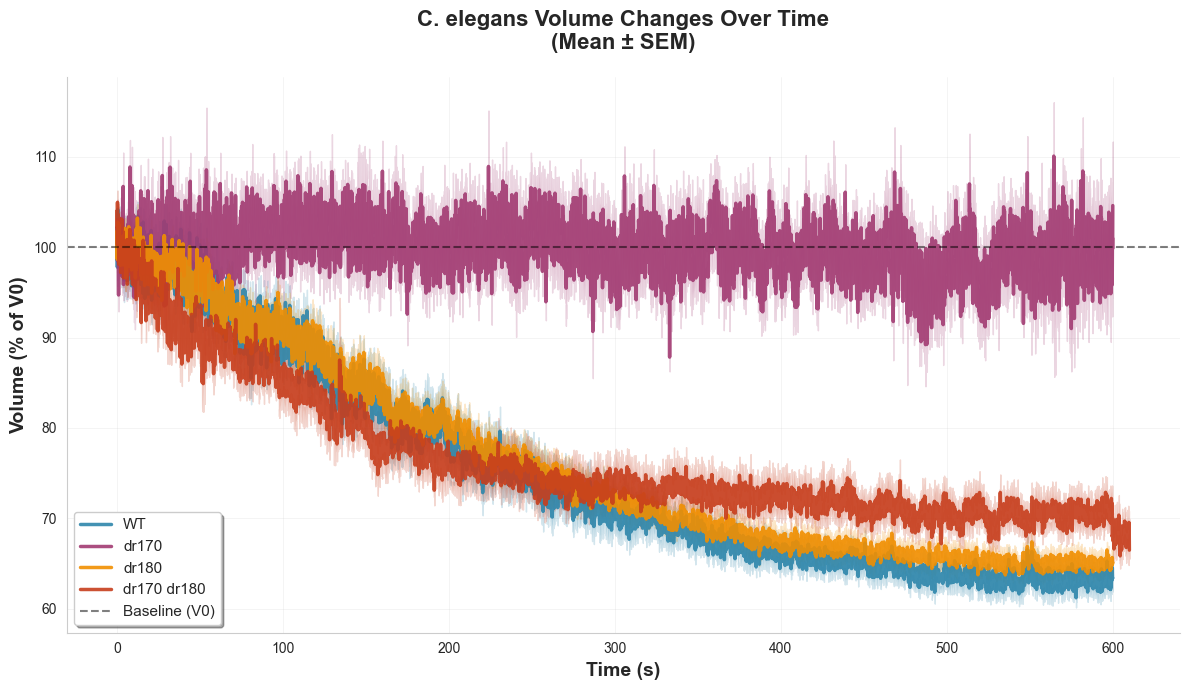

Figure saved as 'volume_analysis_all_genotypes.png'


In [ ]:
# Smooth and plot all genotypes
fig, ax = plt.subplots(figsize=(12, 7))

for genotype_name, data in genotype_data.items():
    summary_df = data['summary']
    
    # Apply smoothing
    smoothed_df = smooth_data(summary_df, SMOOTHING_WINDOW)
    
    # Plot mean line
    ax.plot(smoothed_df['Time'], smoothed_df['Mean'], 
            label=genotype_name, color=colors[genotype_name]['line'], 
            linewidth=2.5, alpha=0.9)
    
    # Plot SEM envelope
    ax.fill_between(smoothed_df['Time'], 
                     smoothed_df['Mean'] - smoothed_df['SEM'],
                     smoothed_df['Mean'] + smoothed_df['SEM'],
                     color=colors[genotype_name]['fill'], alpha=0.5)

# Formatting
ax.axhline(y=100, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel('Time (s)', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume (% of V0)', fontsize=14, fontweight='bold')
ax.set_title(f'C. elegans Volume Changes Over Time\n(Mean ± SEM, {SMOOTHING_WINDOW}s smoothing)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=True, shadow=True, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('volume_analysis_all_genotypes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'volume_analysis_all_genotypes.png'")

## Step 11: Print Summary Statistics

In [11]:
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

for genotype_name, data in genotype_data.items():
    summary_df = data['summary']
    
    print(f"\n{genotype_name}:")
    print("-" * 40)
    print(f"  Mean N tracks: {summary_df['N'].mean():.1f}")
    print(f"  Final volume: {summary_df['Mean'].iloc[-1]:.2f} ± {summary_df['SEM'].iloc[-1]:.2f}%")
    print(f"  Max volume: {summary_df['Mean'].max():.2f}%")
    print(f"  Min volume: {summary_df['Mean'].min():.2f}%")
    print(f"  Range: {summary_df['Mean'].max() - summary_df['Mean'].min():.2f}%")

SUMMARY STATISTICS

WT:
----------------------------------------
  Mean N tracks: 17.9
  Final volume: 60.13 ± 2.29%
  Max volume: 104.17%
  Min volume: 58.07%
  Range: 46.10%

dr170:
----------------------------------------
  Mean N tracks: 8.8
  Final volume: 104.59 ± 7.09%
  Max volume: 110.07%
  Min volume: 87.83%
  Range: 22.24%

dr180:
----------------------------------------
  Mean N tracks: 32.2
  Final volume: 60.13 ± 2.29%
  Max volume: 103.21%
  Min volume: 58.07%
  Range: 45.14%

dr170 dr180:
----------------------------------------
  Mean N tracks: 15.4
  Final volume: 66.48 ± 0.95%
  Max volume: 104.95%
  Min volume: 65.84%
  Range: 39.11%


## Step 12: Export Data to CSV

In [12]:
# Export individual genotype summaries
for genotype_name, data in genotype_data.items():
    filename = f'summary_{genotype_name.replace(" ", "_")}.csv'
    data['summary'].to_csv(filename, index=False)
    print(f"Saved {filename}")

# Create combined summary file
combined_data = []
for genotype_name, data in genotype_data.items():
    summary_df = data['summary'].copy()
    summary_df['Genotype'] = genotype_name
    combined_data.append(summary_df)

combined_df = pd.concat(combined_data, ignore_index=True)
combined_df = combined_df[['Genotype', 'Time', 'Mean', 'SEM', 'N']]
combined_df.to_csv('summary_all_genotypes.csv', index=False)
print("\nSaved summary_all_genotypes.csv")
print("\n✓ All data exported successfully!")

Saved summary_WT.csv
Saved summary_dr170.csv
Saved summary_dr180.csv
Saved summary_dr170_dr180.csv

Saved summary_all_genotypes.csv

✓ All data exported successfully!

Saved summary_all_genotypes.csv

✓ All data exported successfully!


## Step 13: Statistical Comparisons (Optional)

In [13]:
# This cell requires reloading the normalized data for each genotype
# For now, we'll compare the final mean values from the summaries

print("="*80)
print("FINAL TIMEPOINT COMPARISON")
print("="*80)

for genotype_name, data in genotype_data.items():
    summary_df = data['summary']
    final_mean = summary_df['Mean'].iloc[-1]
    final_sem = summary_df['SEM'].iloc[-1]
    final_n = summary_df['N'].iloc[-1]
    
    print(f"\n{genotype_name}:")
    print(f"  Volume: {final_mean:.2f} ± {final_sem:.2f}%")
    print(f"  N: {final_n}")

FINAL TIMEPOINT COMPARISON

WT:
  Volume: 60.13 ± 2.29%
  N: 5

dr170:
  Volume: 104.59 ± 7.09%
  N: 4

dr180:
  Volume: 60.13 ± 2.29%
  N: 5

dr170 dr180:
  Volume: 66.48 ± 0.95%
  N: 4


## Analysis Complete!

### What we did:
1. ✓ Loaded area, length, and fit data for all genotypes
2. ✓ Calculated volume using: $V \approx \frac{\pi \cdot Area^2}{4 \cdot Length}$
3. ✓ Filtered tracks by fit quality (fit > 0.9)
4. ✓ Normalized to V0 (average volume over first 5 seconds)
5. ✓ Calculated mean ± SEM for each genotype
6. ✓ Created visualizations
7. ✓ Exported results to CSV files

### Output files:
- `volume_analysis_all_genotypes.png`
- `summary_all_genotypes.csv`
- `summary_WT.csv`, `summary_dr170.csv`, etc.